## Market Environment ##

Unlike supervised learning tasks that require a dataset that a model can learn from, reinforcement learning requires an environement that an agent can interact with and learn in. Here, we'll use the historical stock and other financial data we investgated in the Data EDA notebook to build an environment for the reinforcement learning agent.

To start, we'll import the required libraries.

In [266]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

%matplotlib inline

Next, we'll import some functions and classes we defined in the marketenv and simplerl packages, which were developed for this project. 

In [264]:
from marketenv import make_env, MarketMonitor, TradeActionWrapper
from simplerl import RandomAgent, evaluate, MarketMonitorHook

The first environment developed was a miniature version of the market, consisting of 4 assets. The asset prices are simulated using correlated Geometric Brownian Motion (GBM). GBM assumes that returns are normally distributed and, therefore, the prices are lognormally distributed. You can read more about GBM here: https://en.wikipedia.org/wiki/Geometric_Brownian_motion. While we already know returns are not normally distributed (the distributions generally have fatter tails and are more peaked), GBM is a regularly used model of stock prices (and is actually an underlying assumption of the Black-Scholes option pricing model).

As described in the aforementioned Wikipedia article, there are a handful of reasons to use GBM to model stock prices:
1. The expected returns of GBM are independent of the value of the process (stock price).
2. A GBM process only assumes positive values, just like real stock prices.
3. A GBM process shows the same kind of 'roughness' in its paths as we see in real stock prices.

However, it is not a completely realistic model by any means:
1. For real stock prices, volatility changes over time (possibly stochastically), but in GBM, volatility is assumed constant.
2. Stock prices often show jumps caused by unpredictable events or news, but in GBM, the path is continuous (no discontinuity).

Another major benefit of GBM is that it is very easy to use in a simulation, and we can easily incorporate correlation between different assets.

The MiniMarket environment, which we'll take a look at in more detail below, uses two different regimes - a bull market regime and a bear market regime. Each regime is characterized by a different multivariate normal distribution, which is the used to calculate returns. The current regime at any point in time is determined by a Markov chain. The return distributions were estimated using the mean returns, return standard deviations, and correlation matrix for 4 financial time series. The initial state probabilities and transition probability matrix for the Markov chain were estimated using the bull and bear market regimes we explored in the Data EDA notebook.

To make this description a little more concrete, let's plot one of the simulations. The bottom graph shows which regime the environment is currently in, with 1 being a bear market and 0 being a bull market.

In [41]:
def plot_simulation(simulation, regime, labels):
    top = plt.subplot2grid((5, 5), (0, 0), rowspan = 4, colspan = 5)
    bottom = plt.subplot2grid((5, 5), (4, 0), rowspan = 1, colspan = 5)
    
    for i in range(simulation.shape[1]):
        top.plot(simulation[:, i], label = labels[i])
        
    bottom.plot(regime)
    
    return top, bottom

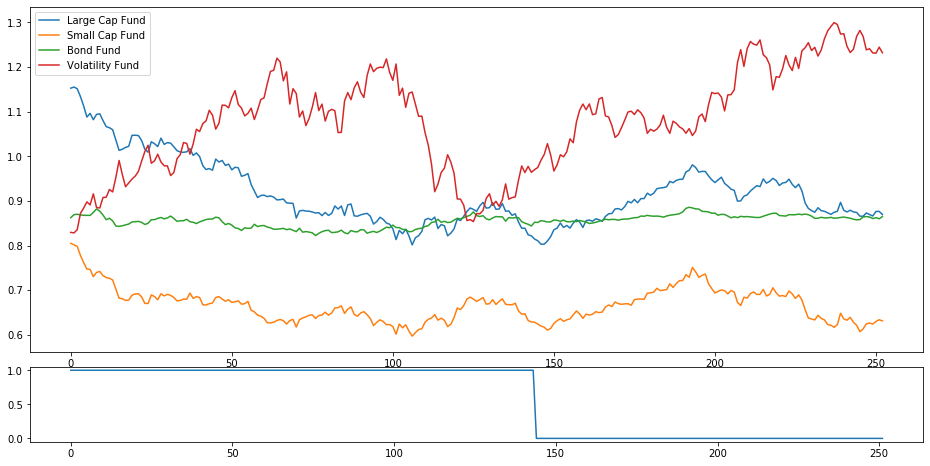

In [99]:
labels = ['Large Cap Fund', 'Small Cap Fund', 'Bond Fund', 'Volatility Fund']
simulation, info = env._simulator.simulate()

fig = plt.figure(figsize = (16, 8))
plt.title('Simulation')
top, bottom = plot_simulation(simulation, info['regimes'], labels)
top.legend(loc = 'upper left')
plt.show()

Now that we've described how stock prices are generated in this environment, let's look at how everything works.

The environment is modeled after the OpenAI Gym environments, where the environment has 4 main methods: reset, step, seed, and close. Seed sets the random seed for the environment, and close shuts the environment down and cleans up any objects and open processes. Reset starts a new episode for the environment, and step takes an action from the agent and transitions from the current observation to the next observation, returning the next observation, the reward for the time step, a boolean indicating whether the environment is in a terminal state (i.e., is over), and a dictionary of other, possibly useful information.

So let's start by creating the environment and starting an episode.

In [292]:
env = make_env('MiniMarket-v2')
obs = env.reset()
print('First observation:\n', obs)

First observation:
 [1.00000000e+04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.20753736e-01 1.19586150e+00 8.75288773e-01
 9.29675046e-01]


The observation is a vector with 8 items: 
1. The first item is the current cash balance the agent has available to purchase assets. In this environment, the agent starts with \$10,000.
2. Items two through five are the number of shares owned for each asset. At the beginning, the agent does not own any shares, so these are all 0.
3. The last four items are the current prices of the assets available to trade. Initial prices are selected from a uniform distribution: $S_{0} \in [0.8, 1.2]$.

The total portfolio value is calculated as $P_{t} = C_{t} + p_{t} \cdot S_{t}$, where $P_{t}$ is the portfolio value at time $t$, $C_{t}$ is the cash balance at time $t$, $p_{t} \in \mathbb{N}^{4}$ is the vector of positions held at time $t$, and $S_{t} \in \mathbb{R}^{4}$ is the vector of prices at time $t$. The environment has some helpful properties for calculating this.

In [293]:
print('Initial portfolio value:', env.portfolio_value)

Initial portfolio value: 10000.0


To transition to the next time step, we pass the step method a valid action. Here, we'll purchase 2,000 shares of each asset.

In [294]:
action = [2000, 2000, 2000, 2000]
obs, reward, terminal, info = env.step(action)
print('Second observation:\n', obs)

Second observation:
 [2.35684189e+03 2.00000000e+03 2.00000000e+03 2.00000000e+03
 2.00000000e+03 8.19724475e-01 1.19784040e+00 8.73930232e-01
 9.49086484e-01]


When taking a step, the agent first makes any sales and then makes any purchases, so the cash from the sale, is available for the purchase. If an agent tries to purchase more shares than it has cash for or if it tries to sell more shares than it owns, the environment throws an errow, so we'll have to make sure the agent takes valid actions.

The agent also receives a reward, which is equal to the change in portfolio value as we can see below.

In [295]:
print('New portfolio value:', env.portfolio_value)
print('Reward received:', reward)

New portfolio value: 10038.005068204737
Reward received: 38.005068204736745


The MiniMarket environment was primarily used for testing and debugging agents. Most agents learned to immediately purchase one or a combination of the higher returning assets and hold them until the end of the episode - no other trades were made. It is likely that the agents would require significant training before they were able to identify the current regime and then adjust the portfolio as necessary.

The next iteration of the environment was more complex, using the historical stock data for the 10 stocks and 14 financial time series investigated in the Data EDA notebook. As such, the observations returned are $o \in \mathbb{R}^{55}$: 
1. The the cash balance.
2. The 10 stocks that the agent can trade.
3. The daily volume and day's price range for each stock (totaling another 20 time series, two for each stock).
4. The 14 other financial time series the agent can use to try to make better informed trade decisions.

In [298]:
env = make_env('Market-v2')
obs = env.reset()
print('Shape of observation:', obs.shape)

Shape of observation: (55,)


Each time the environment is reset, the environment randomly selects a sequential series of 250 days worth of data (about one year as there are 252 trading days in a year) from the historical data collected. Let's take a look at a historical simulation.

In [299]:
def plot_historical_sim(simualtion, labels):
    for i in range(simulation.shape[1]):
        plt.plot(simulation[:, i], label = labels[i])

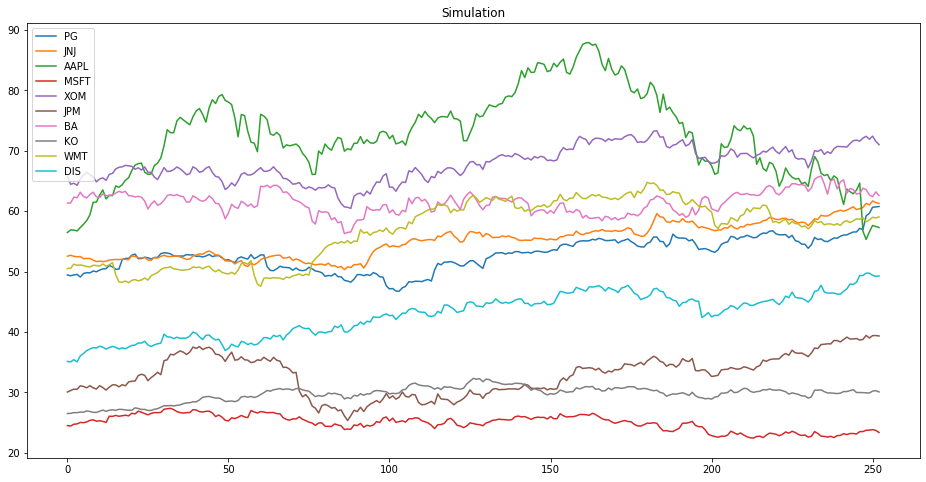

In [302]:
stock_tickers = ['PG', 'JNJ', 'AAPL', 'MSFT', 'XOM', 
                 'JPM', 'BA', 'KO', 'WMT', 'DIS']
simulation, info = env._simulator.simulate()
simulation = simulation[:, :len(stock_tickers)]

fig = plt.figure(figsize = (16, 8))
plt.title('Simulation')
plot_historical_sim(simulation, stock_tickers)
plt.legend(loc = 'upper left')
plt.show()

The environment does not normalize the prices in any way, so let's start all the series at 1.0 to see how each asset grows over time.

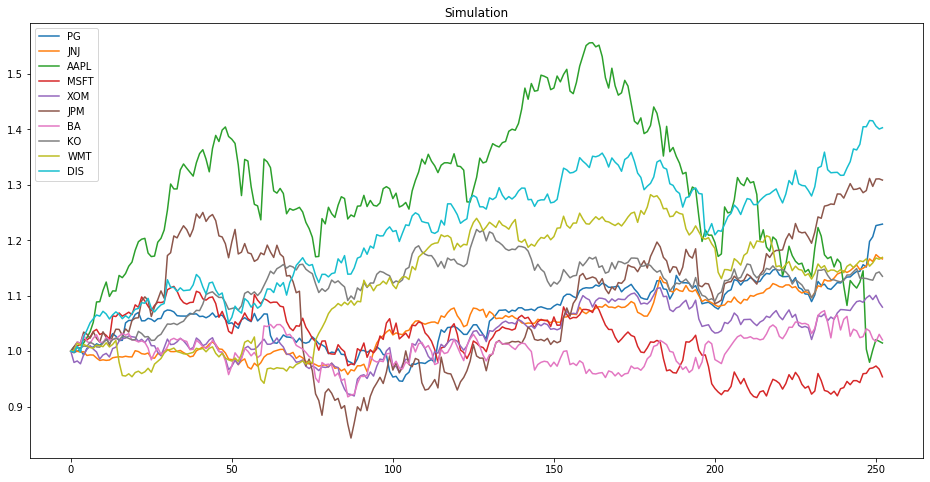

In [303]:
simulation = simulation / simulation[0, :]

fig = plt.figure(figsize = (16, 8))
plt.title('Simulation')
plot_historical_sim(simulation, stock_tickers)
plt.legend(loc = 'upper left')
plt.show()

This environment turned out to be very challenging. Learned policies got stuck in local minimums corresponding to suboptimal policies. In many cases, the agents tried to take the same action in all states, even with heavy exploration. 

Due to hardware constraints, training was terminated if it looked like the agent wasn't learning or was stuck after a couple of hundred episodes, so an agent may learn to act intelligently in this environment given more training time. 

Additionally, this task is quite a bit harder as there are more assets to manage. Simply adding noise to the policy for exploration didn't allow the agent to explore a sufficient number of portfolio combinations. More sophisticated exploration is likely necessary for the agent to learn to manage a large number of assets with a constrained initial cash balance.

After struggling to train a agent in the larger market environment (at least in a reasonable amount of time), the environment was simplified, reducing the number of assets available to trade from ten to one. Now, instead of trading individual shares, the agent can trade an index fund, tracking the WILL5000, a broad market equity index. The WILL5000 was originally part of the other 14 non-tradable financial data series the agent had access to, so now the observations from the environment are $o \in \mathbb{R}^{16}$, with the cash balance, the number of shares held, the current price for the WILL5000, and the other 13 financial time series. 

The action space went from $a \in \mathbb{N}^{10}$ to $a \in \mathbb{N}^{1}$ - a much simpler task. Not only does the agent have fewer decisions to make at each time step, but now it doesn't have to worry about not having cash available to reallocate the portfolio, which was a major problem in the larger environment when adding random noise to the policy for exploration.

Let's take a look at the final environment.

In [312]:
env = make_env('Market-v3')
obs = env.reset()
print('First observation:\n', obs)

First observation:
 [1.00000e+04 0.00000e+00 5.25500e+01 2.56000e+00 2.94000e+00 1.53000e+00
 6.80000e-01 3.80000e-01 1.70000e-01 2.61648e+03 5.64000e+00 9.30200e+01
 4.96000e+00 2.79000e+00 2.18500e+01 1.94500e+01]


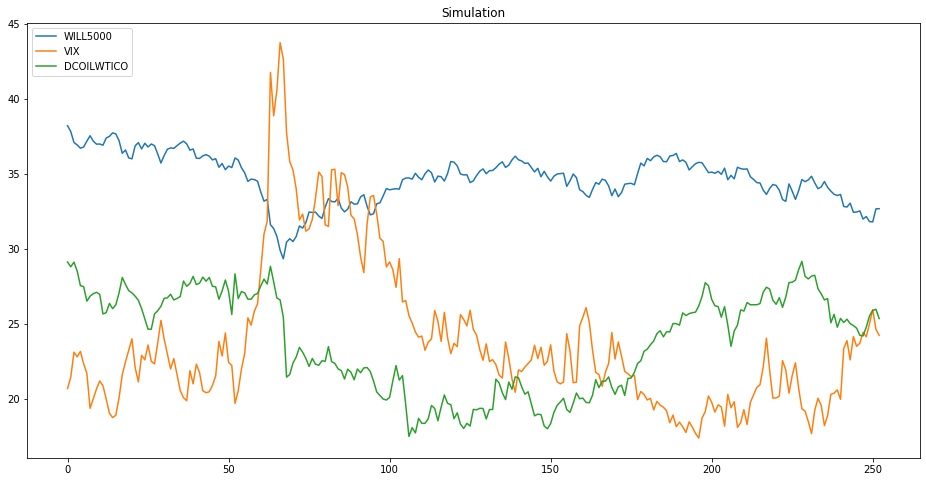

In [311]:
simulation, info = env._simulator.simulate()
simulation = simulation[:, [0, -2, -5]]

fig = plt.figure(figsize = (16, 8))
plt.title('Simulation')
plot_historical_sim(simulation, ['WILL5000', 'VIX', 'DCOILWTICO'])
plt.legend(loc = 'upper left')
plt.show()

The above historical simulation plots the WILL5000, the tradable asset, the VIX, an index measuring market volatility, and DCOILWTICO, an index of crude oil prices. As we can see, the WILL5000 and the VIX are generally negatively correlated, which we would expect, and there is some positive correlation between the WILL5000 and oil prices (at least for the above episode). We don't plot the other series here as the scale of each can be quite different (e.g., the NASDAQ market index is in the thousands). 

Now that we have the final version of the environment we'll use for this project, let's look a little closer at how an agent interacts with the environment. We'll use a simple random agent for now. The random agent randomly generates an actions, $a \in [-1.0, 1.0]$, we use a wrapper over the environment to map $a$ to $A \in \mathbb{Z}$ , the action the agent ultimately takes. The agent training notebook goes into more detail on the environment wrappers used for things like action mapping and feature engineering.  

Since each episode the environment generates is stochastic, we'll run the agent in the environment 1,000 times to see how well it performs on average.

In [267]:
env = MarketMonitor(env)
env = TradeActionWrapper(env, action_scale = 100.0)

random_agent = RandomAgent(env.action_space)
monitor = MarketMonitorHook(eval_window = 1000, verbose = 100, vector_env = False)

t = time.time()
evaluate(random_agent, env, hooks = [monitor], eval_steps = 250 * 1000, vector_env = False)
print('\nWall time:', (time.time() - t) / 60.0)

Episode 100 | Market Return: -25.81 | Agent Return: -19.39 | Win Rate: 27.00 | Average Spread -6.01
Episode 200 | Market Return: 12.91 | Agent Return: 11.01 | Win Rate: 35.00 | Average Spread -3.68
Episode 300 | Market Return: 47.79 | Agent Return: 20.95 | Win Rate: 34.67 | Average Spread -3.33
Episode 400 | Market Return: 11.07 | Agent Return: 0.69 | Win Rate: 33.75 | Average Spread -3.36
Episode 500 | Market Return: 26.47 | Agent Return: 9.48 | Win Rate: 33.40 | Average Spread -3.36
Episode 600 | Market Return: 9.98 | Agent Return: 12.41 | Win Rate: 31.50 | Average Spread -3.85
Episode 700 | Market Return: -17.96 | Agent Return: -15.05 | Win Rate: 31.86 | Average Spread -3.78
Episode 800 | Market Return: 25.55 | Agent Return: 17.26 | Win Rate: 31.37 | Average Spread -3.91
Episode 900 | Market Return: 26.50 | Agent Return: 6.72 | Win Rate: 31.11 | Average Spread -4.06
Episode 1000 | Market Return: 15.09 | Agent Return: 7.56 | Win Rate: 30.70 | Average Spread -4.14

Wall time: 1.422309

Over 1,000 episodes, the agent beat the market (i.e., had a higher return than just buying at the beginning and holding until the end) about 30% of the time. The average return spread between the agent's return and the market return was about -4%. Unsurprisingly, the random agent didn't do too well in the environment.

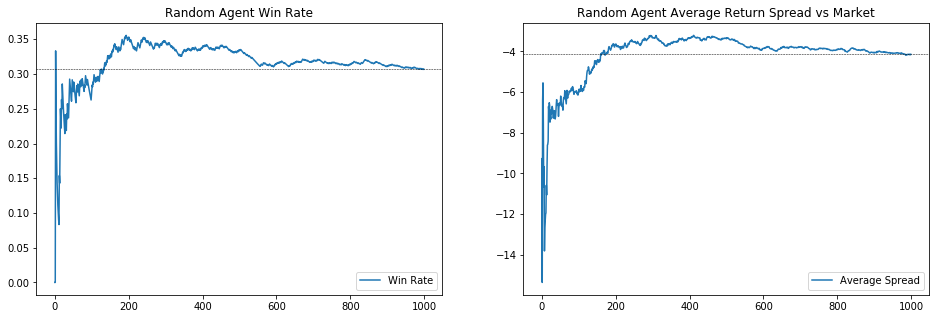

In [269]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

win_rate = pd.Series(monitor.agent_wins).rolling(1000, min_periods = 1).mean()

ax[0].title.set_text('Random Agent Win Rate')
ax[0].plot(win_rate.to_numpy(), label = 'Win Rate')
ax[0].axhline(win_rate.iat[-1], color = 'k', linewidth = 0.5, linestyle = '--')
ax[0].legend(loc = 'lower right')

difference = np.asarray(monitor.agent_returns) - np.asarray(monitor.market_returns)
average_spread = pd.Series(difference).rolling(1000, min_periods = 1).mean()

ax[1].title.set_text('Random Agent Average Return Spread vs Market')
ax[1].plot(average_spread.to_numpy(), label = 'Average Spread')
ax[1].axhline(average_spread.iat[-1], color = 'k', linewidth = 0.5, linestyle = '--')
ax[1].legend(loc = 'lower right')

plt.show()

Finally, let's take a look at the decisions the agent made. The function below will help us generate an episode and plot the agent's actions.

In [285]:
def plot_agent_trades(agent, env = None, starting = 1, vector_env = False):
    if env is None:
        env = agent.env
    
    assert (not agent.training), 'Set the agent to eval before calling plot_actions'
    assert ('MarketMonitor' in str(env))
    
    raw_actions = []
    clipped_actions = []
    
    obs = env.reset()
    done = False

    while not done:
        action = agent.action(obs)
        raw_actions.append(action)
        
        obs, _, done, _ = env.step(action)
        clipped_actions.append(env.action_history[-1])
        
        if vector_env:
            done = done[0]
    
    fix, ax = plt.subplots(2, 1, figsize = (16, 12))
    
    ax[0].title.set_text("WILL5000 and Agent's Actions")
    actions = np.array(env.episode_history[-1][1])[:, 0]
    observations = np.array(env.episode_history[-1][0])[1:, 2]

    colors = []
    for action in actions:
        if np.sign(action) == 1:
            colors.append('g')
        elif np.sign(action) == -1:
            colors.append('r')
        else:
            colors.append('w')

    x = np.arange(len(observations)) + 1
    ax[0].scatter(x, observations, color = colors)
    ax[0].plot(x, observations, label = 'WILL5000')
    
    ax[0].axvline(starting, linestyle = '--', color = 'k')
    ax[0].legend(loc = 'upper left')
    
    ax[1].title.set_text('Predicted Actions vs Actions Taken ')
    
    ax2 = ax[1].twinx()
    
    raw_actions = np.array(raw_actions).squeeze()
    clipped_actions = np.array(clipped_actions).squeeze()
    
    if starting > 1:
        padding = np.zeros(starting)
        raw_actions = np.concatenate([padding * np.nan, raw_actions], axis = 0)
        clipped_actions = np.concatenate([padding, clipped_actions], axis = 0)
    
    line1 = ax[1].plot(x, raw_actions, color = 'r', label = 'Predicted Actions')
    line2 = ax2.plot(x, clipped_actions, label = 'Actions Taken')
    
    miny, maxy = ax[1].get_ylim()
    ax[1].set_ylim(-max(abs(miny), abs(maxy)) - 1e-1, max(abs(miny), abs(maxy)) + 1e-1)
    
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(-max(abs(miny), abs(maxy)), max(abs(miny), abs(maxy)))
             
    ax[1].axhline(0, linestyle = '--', color = 'k')
             
    plots = [line1[0], line2[0]]
    labels = [p.get_label() for p in plots]
    ax[1].legend(plots, labels, loc = 'upper left')
    plt.show()

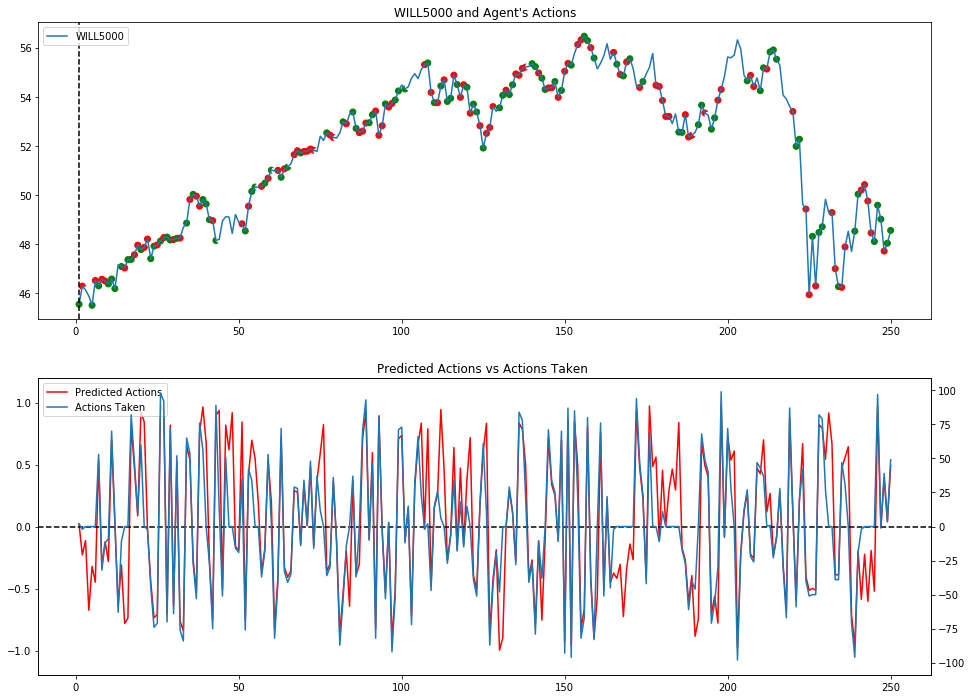

In [286]:
plot_agent_trades(random_agent, env)

The top graph shows the price trend for the WILL5000 for the generated episode. The red and green dots are when the agent make a sale and purchase, respectively. As we can see, the agent's actions have no relationship to the actual time series.

The bottom graph shows the agents raw actions, $a$, and mapped actions, $A$. Again, $a \in [-1.0, 1.0]$, which we can see as the red line (left axis). The actual actions made, $A$, are the blue line (right axis). In general, a raw action of 1.0 maps to purchasing 100 shares and a raw action of -1 maps to selling 100 shares. It is difficult to see here, but, if an agent doesn't have enough cash to make a purchase, $a > 1$ is mapped to 0, and, if an agent doesn't have enough shares to sell, $a < 1$ is mapped to the number of shares held (or 0 if no shares are held). 

That is it for this notebook. Now that we have some data and an environment for the agent to interact in, we'll start training an agent!